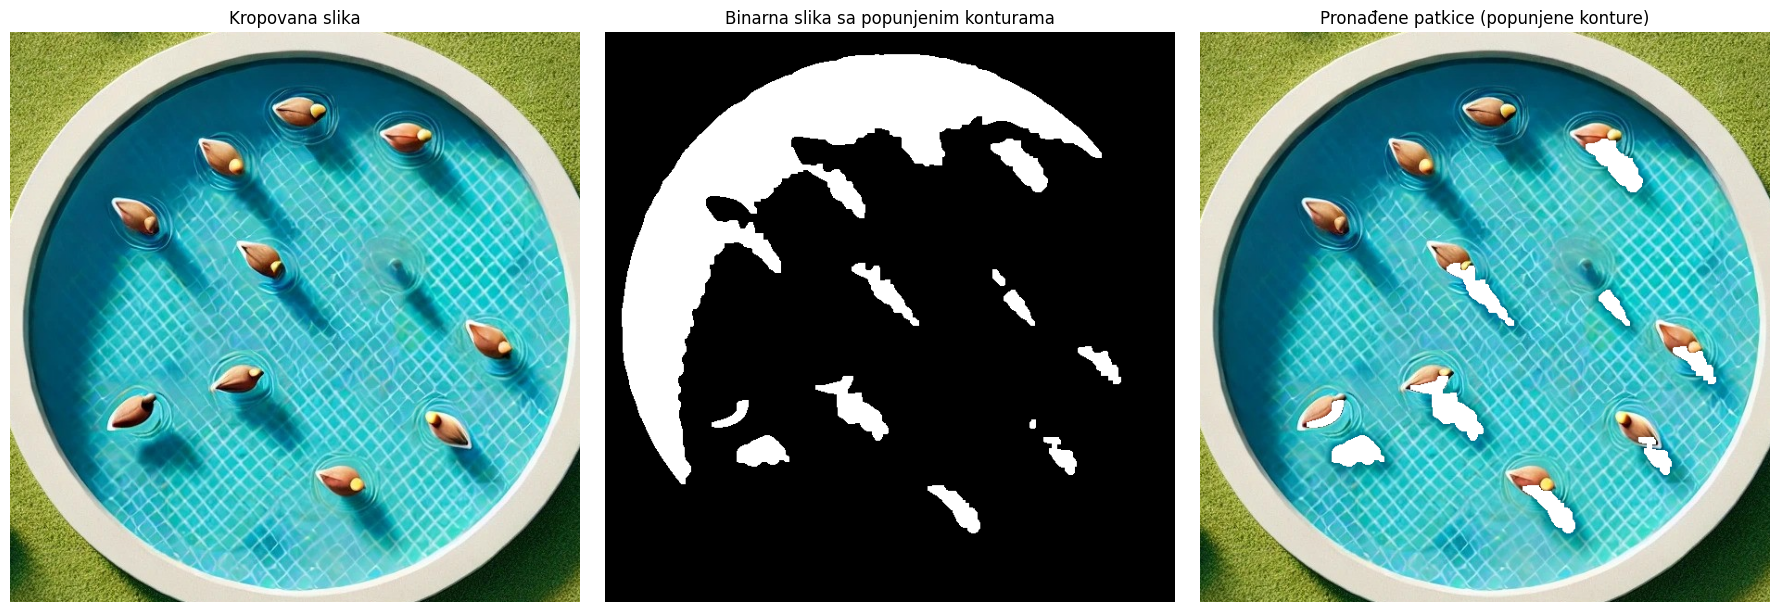

Broj patkica na slici data/picture_1.jpg: 9


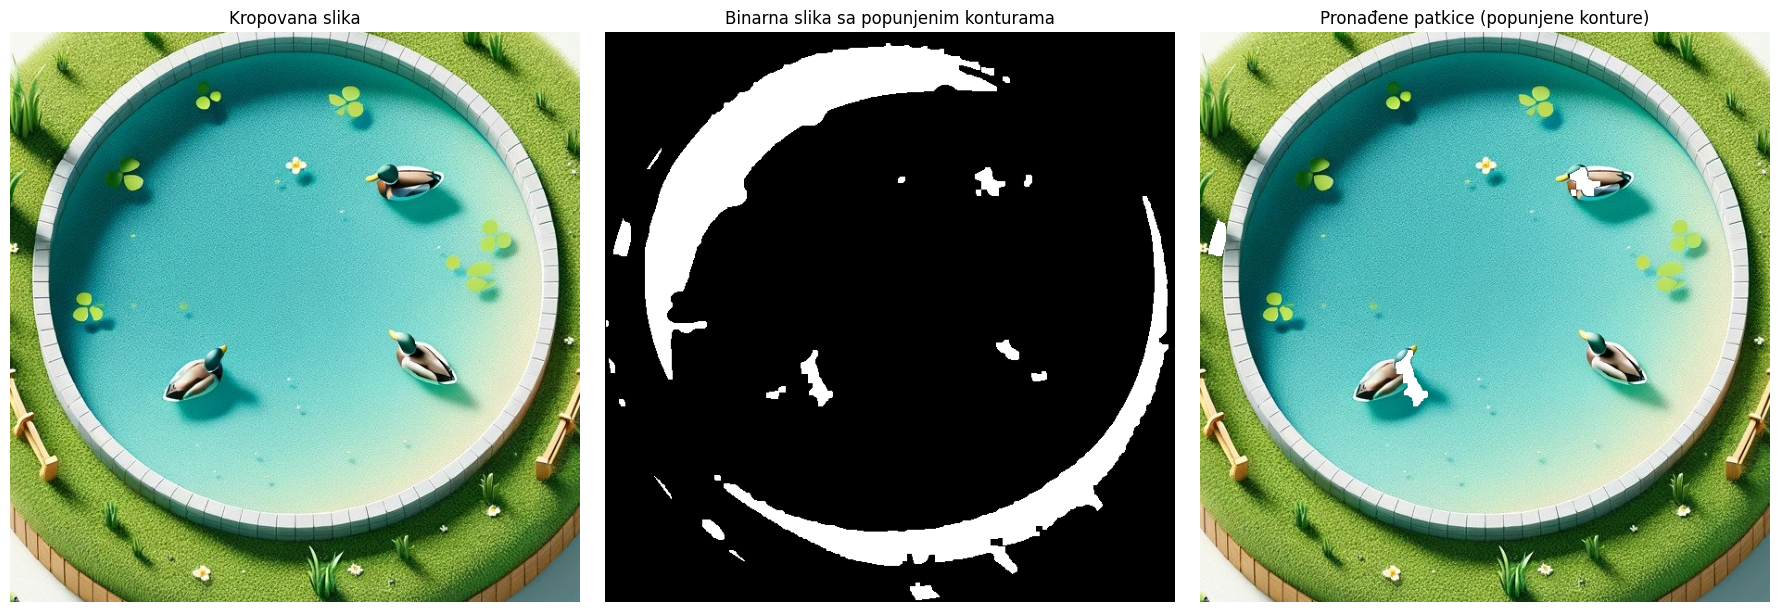

Broj patkica na slici data/picture_2.jpg: 3


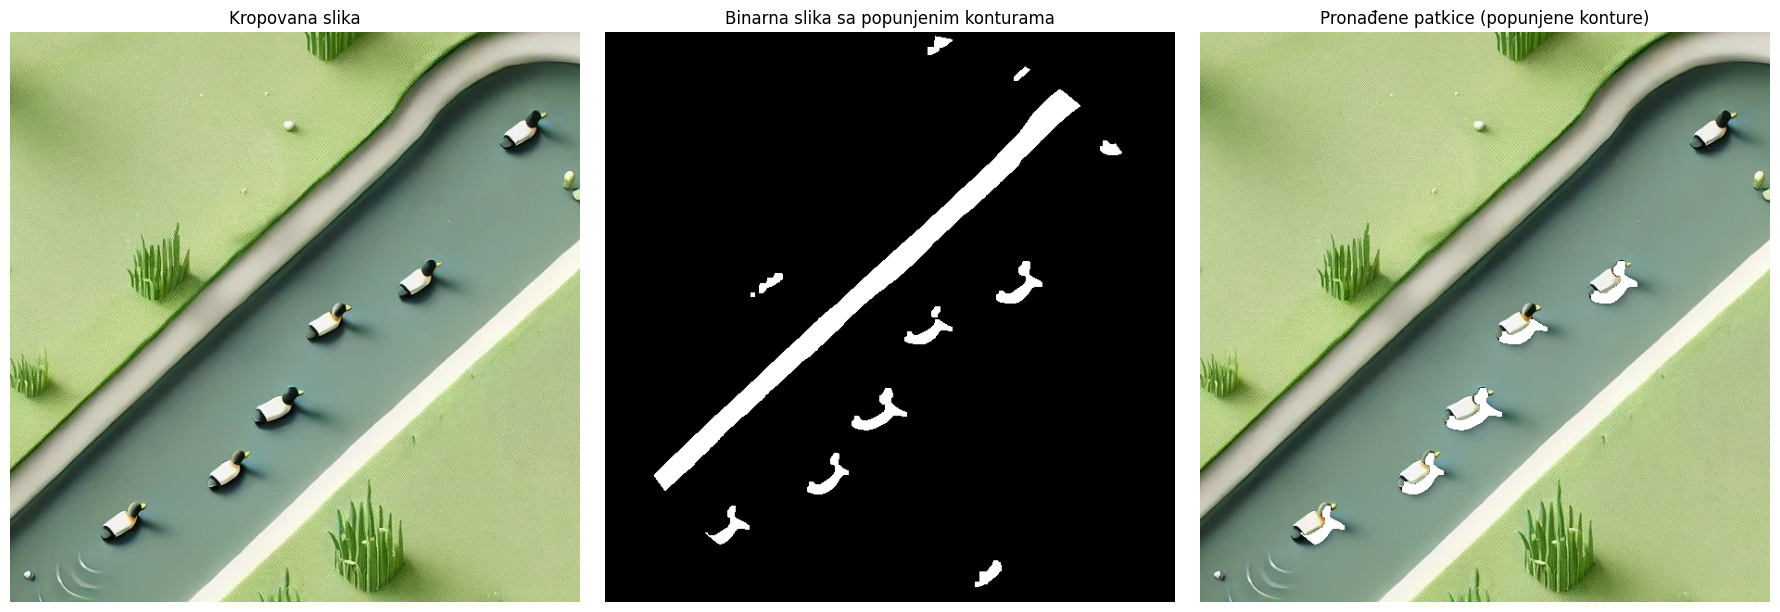

Broj patkica na slici data/picture_3.jpg: 5


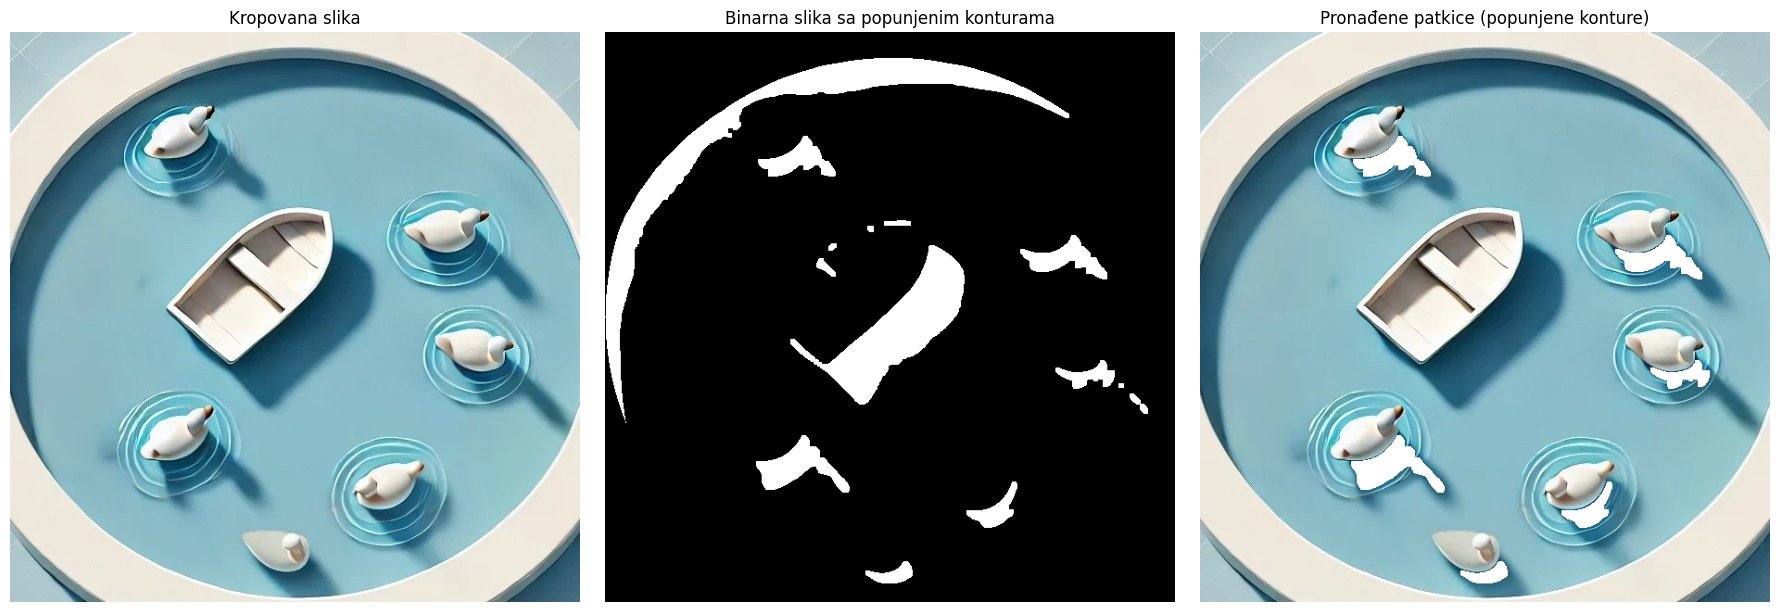

Broj patkica na slici data/picture_4.jpg: 6


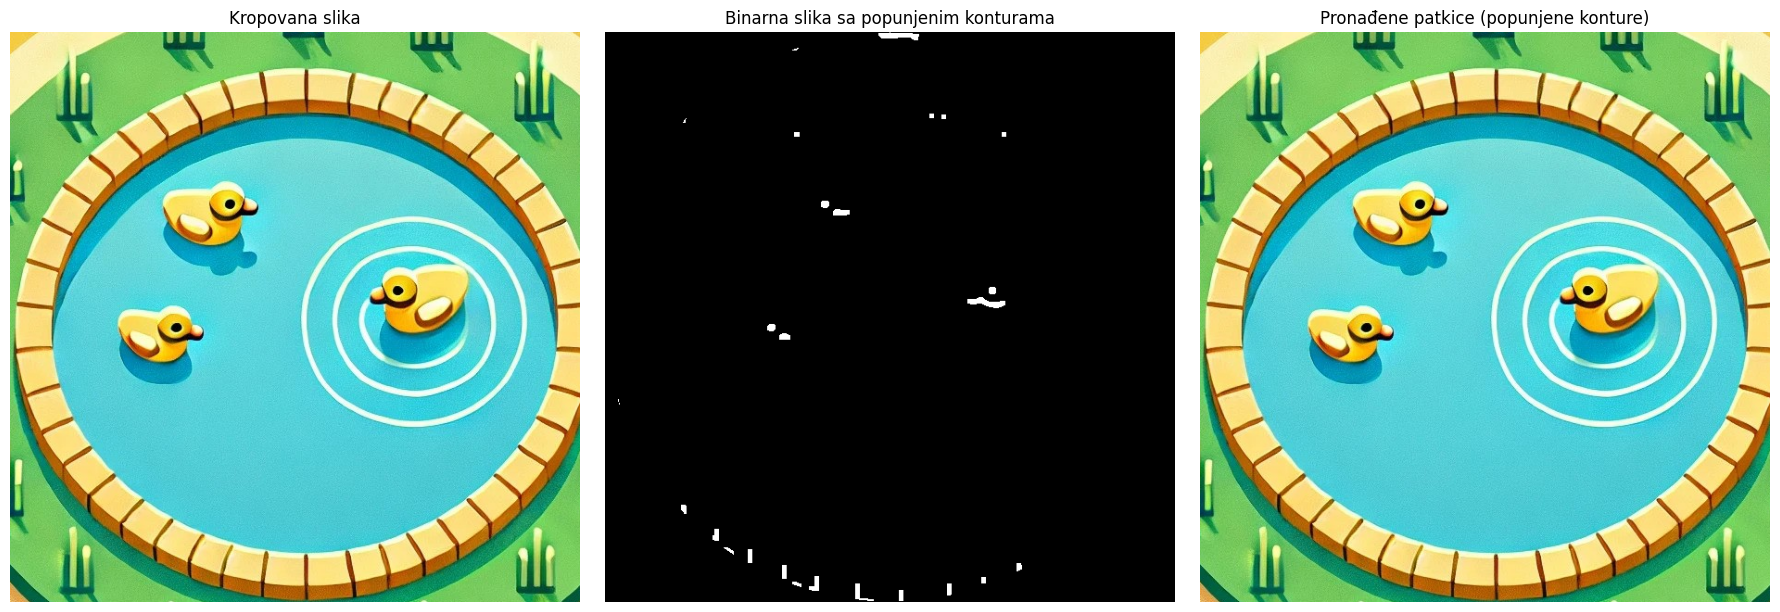

Broj patkica na slici data/picture_5.jpg: 0


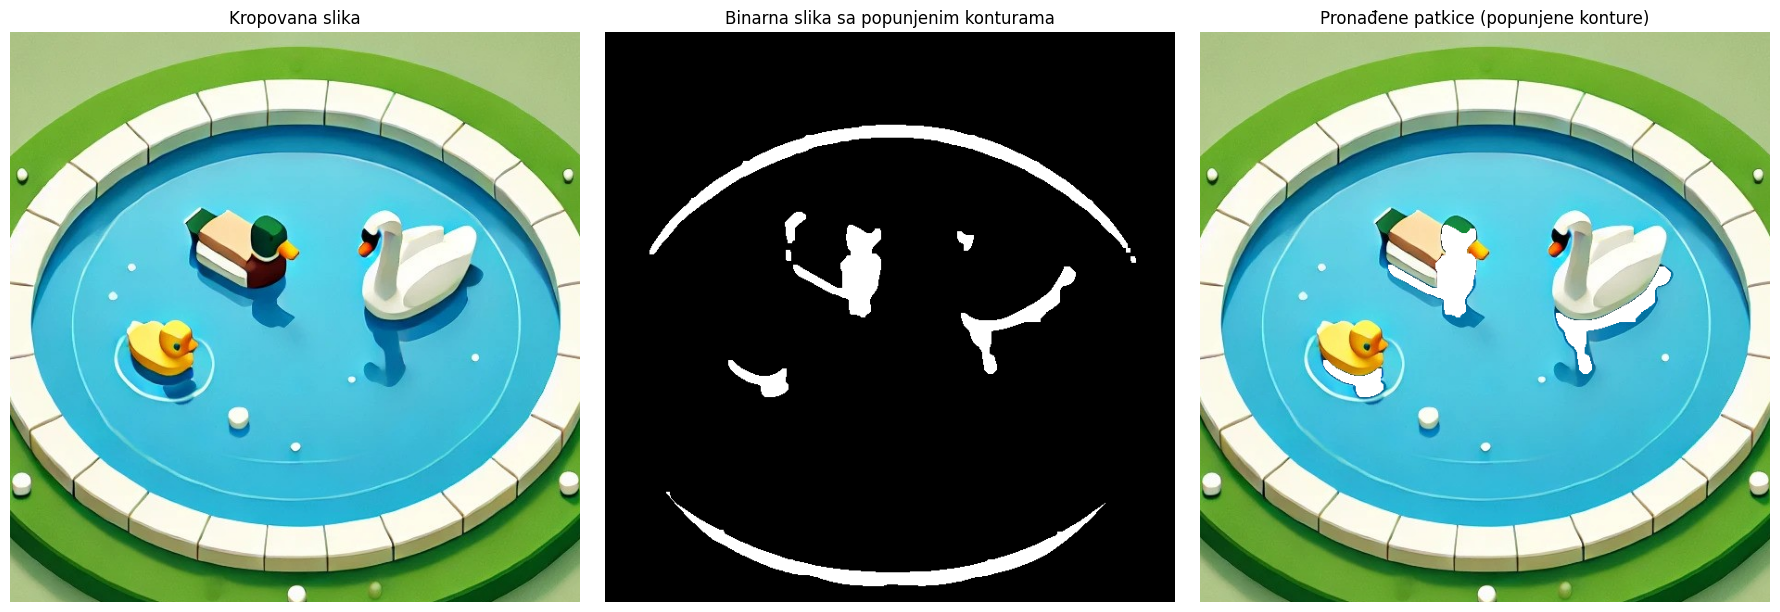

Broj patkica na slici data/picture_6.jpg: 3


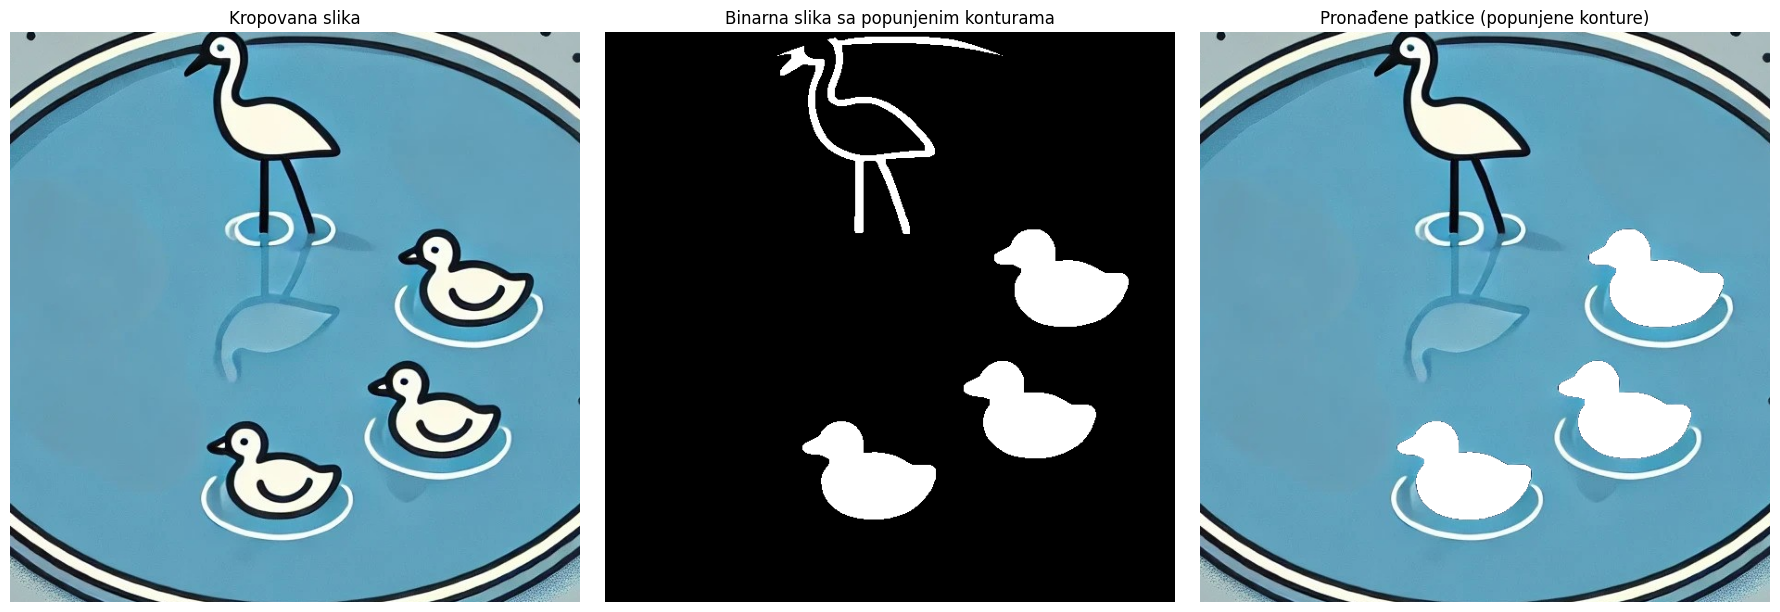

Broj patkica na slici data/picture_7.jpg: 3


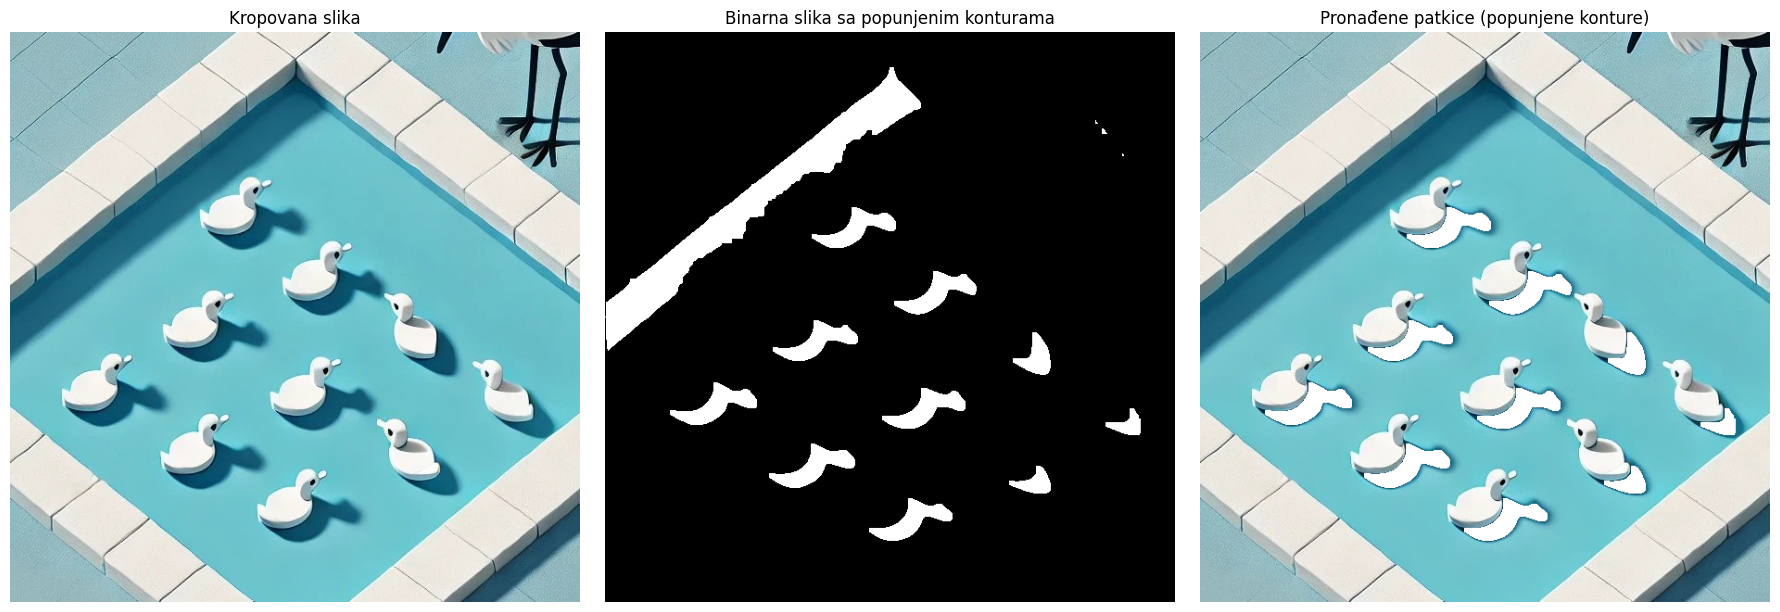

Broj patkica na slici data/picture_8.jpg: 10


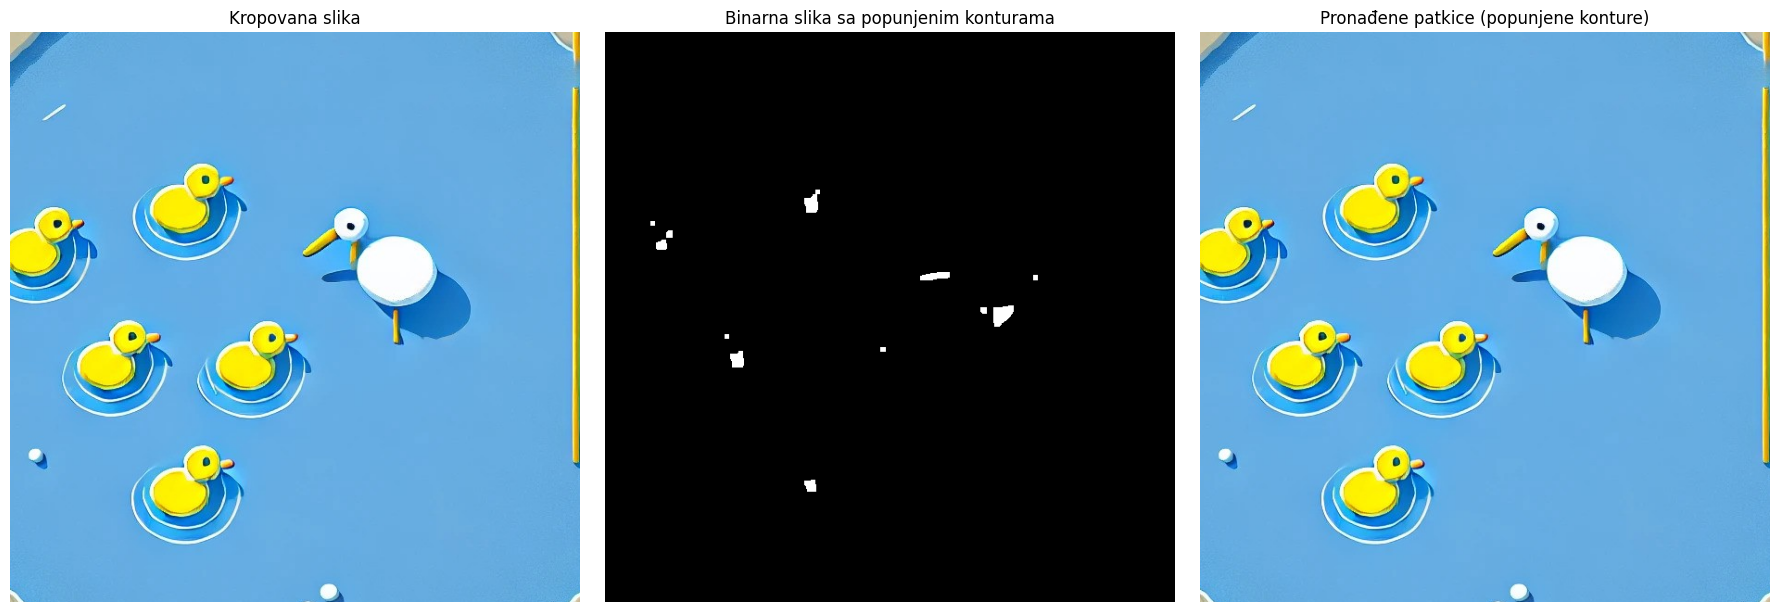

Broj patkica na slici data/picture_9.jpg: 0


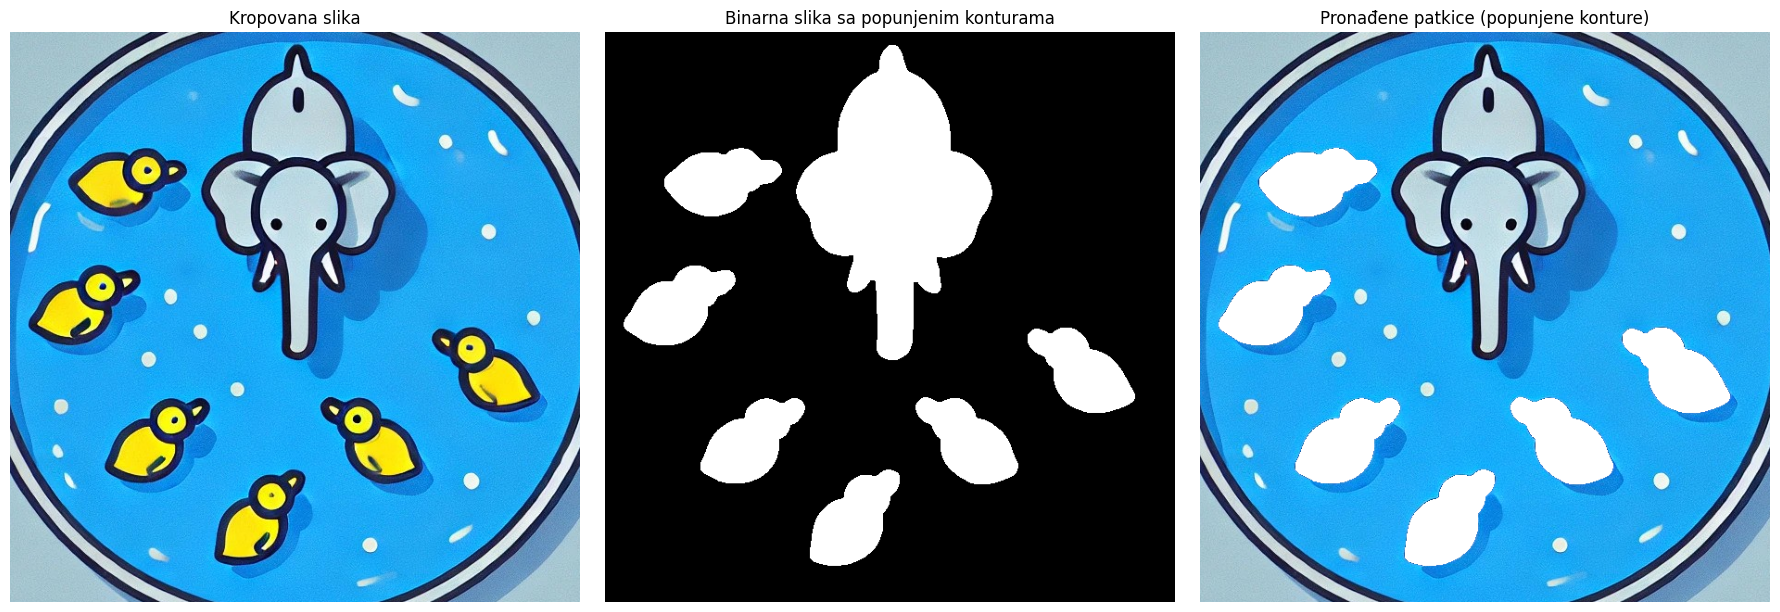

Broj patkica na slici data/picture_10.jpg: 6
MAE: 1.1


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
def find_ducks(image_path, min_area=500, max_area=5000):
    # Učitavanje slike
    img = cv2.imread(image_path)
    
    # Kropovanje slike (odabir centralnog dela)
    h, w = img.shape[:2]
    crop_img = img[h//5:4*h//5, w//5:4*w//5]  # kropovanje centralnog dela slike
    
    # Pravljenje kružne maske koja će ignorisati konture u uglovima
    mask = np.zeros(crop_img.shape[:2], dtype=np.uint8)
    center = (mask.shape[1] // 2, mask.shape[0] // 2)
    radius = min(center)  # Poluprečnik kruga sa malom marginom od ivica
    cv2.circle(mask, center, radius, 255, -1)  # Bela kružna maska
    
    # Zamućenje slike kako bi se smanjio šum
    img_blur = cv2.GaussianBlur(crop_img, (7, 7), 0)  # Povećano zamućenje
    
    # Konverzija u grayscale
    img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    
    # Globalni threshold za binarizaciju
    _, img_bin = cv2.threshold(img_gray, 85, 255, cv2.THRESH_BINARY_INV)
    
    # Morfološko zatvaranje za uklanjanje sitnih tačkica
    kernel = np.ones((5, 5), np.uint8)
    img_bin_cleaned = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)
    
    # Morfološko otvaranje za dodatno uklanjanje sitnih objekata
    img_bin_cleaned = cv2.morphologyEx(img_bin_cleaned, cv2.MORPH_OPEN, kernel)
    
    # Primena kružne maske na binarnu sliku
    img_bin_masked = cv2.bitwise_and(img_bin_cleaned, img_bin_cleaned, mask=mask)
    
    # Detekcija kontura na maskiranoj binarnoj slici
    contours, _ = cv2.findContours(img_bin_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Kreiranje binarne slike sa popunjenim konturama
    img_filled_bin = np.zeros_like(img_bin_masked)
    for contour in contours:
        cv2.drawContours(img_filled_bin, [contour], -1, 255, thickness=cv2.FILLED)  # Popunjavanje kontura belom bojom

    # Ponovna detekcija kontura na popunjenoj binarnoj slici
    filled_contours, _ = cv2.findContours(img_filled_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtriranje kontura prema zadatom opsegu površine
    valid_contours = []
    for contour in filled_contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area or 5980 < area < 6300 or 7700 < area < 9000:  # Filtriranje po površini
            valid_contours.append(contour)

    # Provera broja pronađenih kontura
    if len(valid_contours) == 0:
        print(f'Nema patkica na slici {image_path}. Primena užeg kruga i dilacije...')
        
        # Kreiranje užeg kruga i nove maske
        smaller_radius = int(radius * 0.7)
        small_mask = np.zeros(crop_img.shape[:2], dtype=np.uint8)
        cv2.circle(small_mask, center, smaller_radius, 255, -1)
        img_bin_masked = cv2.bitwise_and(img_bin_cleaned, img_bin_cleaned, mask=small_mask)
        
        # Primena dilatacije na uži krug
        large_kernel = np.ones((10, 10), np.uint8)
        img_bin_dilated = cv2.dilate(img_bin_masked, large_kernel, iterations=2)
        
        # Ponovna detekcija kontura
        contours, _ = cv2.findContours(img_bin_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
            if min_area <= area <= max_area or 5980 < area < 6300 or 7700 < area < 9000:
                valid_contours.append(contour)

    # Kreiranje slike sa validnim konturama
    img_contours = crop_img.copy()
    cv2.drawContours(img_contours, valid_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Prikaz slika
    plt.figure(figsize=(18, 6))
    
    # Prikaz kropovane originalne slike
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
    plt.title('Kropovana slika')
    plt.axis('off')

    # Prikaz binarne slike sa popunjenim konturama
    plt.subplot(1, 3, 2)
    plt.imshow(img_filled_bin, cmap='gray')
    plt.title('Binarna slika sa popunjenim konturama')
    plt.axis('off')

    # Prikaz validnih kontura na originalnoj slici
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    plt.title('Pronađene patkice (popunjene konture)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Prikaz broja pronađenih patkica na osnovu površine
    print(f'Broj patkica na slici {image_path}: {len(valid_contours)}')
    return len(valid_contours)

# Poziv funkcije za svaku sliku sa parametrima za minimalnu i maksimalnu površinu
predicted_counts = []
for i in range(1, 11):
    image_path = f'data/picture_{i}.jpg'
    count = find_ducks(image_path, min_area=400, max_area=5000)  # Podesi min_area i max_area po želji
    predicted_counts.append(count)

# Učitavanje očekivanih vrednosti iz CSV fajla i računanje MAE
duck_count_df = pd.read_csv('data/duck_count.csv')
true_counts = duck_count_df.set_index('picture')['ducks']
predicted_counts_series = pd.Series(predicted_counts, index=true_counts.index)
mae = np.mean(np.abs(predicted_counts_series - true_counts))
print(f"MAE: {mae}")
